In [5]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
# import wrf

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial, generate_ptlst_from_start_end
from plotter import draw_basemap

In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
region = 'baja' ## 'san_juan' 'baja' 'gulf_of_mexico'
## create bounding boxes for regions
d = {'baja': {'ext': [-115., -110., 27., 32.],
              'start_pt': [33.0, -118.],
              'end_pt': [29.0, -110.]},
     
     'san_juan': {'ext': [-109., -105., 37., 39.],
              'start_pt': [38.0, -112.],
              'end_pt': [38.0, -102.]},

     'gulf_of_mexico': {'ext': [-99., -93., 25., 31.],
              'start_pt': [28.0, -100.],
              'end_pt': [31.0, -93.]}
    }
#### FOR BBOX METHOD ####                  
## create a dataset with lats and lons from ext
ext = d[region]['ext']
lats = np.arange(ext[2], ext[3]+0.25, 0.25)
lons = np.arange(ext[0], ext[1]+0.25, 0.25)

print(lats)
print(lons)

[27.   27.25 27.5  27.75 28.   28.25 28.5  28.75 29.   29.25 29.5  29.75
 30.   30.25 30.5  30.75 31.   31.25 31.5  31.75 32.  ]
[-115.   -114.75 -114.5  -114.25 -114.   -113.75 -113.5  -113.25 -113.
 -112.75 -112.5  -112.25 -112.   -111.75 -111.5  -111.25 -111.   -110.75
 -110.5  -110.25 -110.  ]


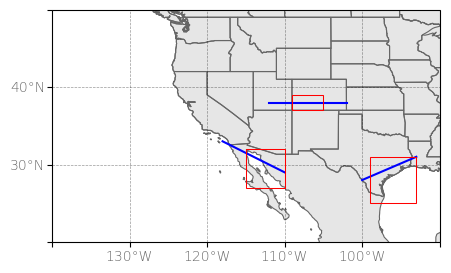

In [4]:
# ## create a simple map to show the areas
nrows = 1
ncols = 1
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,5))

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1], width_ratios = [1], wspace=0.025, hspace=0.05)
## use gs[rows index, columns index] to access grids

## add basemap
ext = [-140., -90., 20, 50]
dx = np.arange(ext[0],ext[1]+10,10)
dy = np.arange(ext[2],ext[3]+10,10)
ax = fig.add_subplot(gs[0, 0], projection=mapcrs)
ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, grid= True, left_lats=True, right_lats=False)
ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
ax.set_extent(ext, datacrs)

for i, domain in enumerate(['san_juan', 'baja', 'gulf_of_mexico']):
    ext3 = d[domain]['ext']
    ax.add_patch(mpatches.Rectangle(xy=[ext3[0], ext3[2]], width=ext3[1]-ext3[0], height=ext3[3]-ext3[2],
                                            fill=False,
                                            edgecolor='r',
                                            linewidth=0.75,
                                            transform=datacrs,
                                            zorder=199))

    ax.plot([d[domain]['start_pt'][1], d[domain]['end_pt'][1]],
            [d[domain]['start_pt'][0], d[domain]['end_pt'][0]], color="blue",
                transform=ccrs.PlateCarree(), zorder=3)

# Show
plt.show()

In [5]:
## load PRISM watershed precip dataset
fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO_sp.nc'
PRISM = xr.open_dataset(fname)
HUC8_lst = PRISM.HUC8.values ## get list of HUC8 IDs

ds_lst = []
## load final trajectory dataset
for i, HUC8_ID in enumerate(HUC8_lst):
    fname = path_to_data + 'preprocessed/ERA5_trajectories/combined_extreme_AR/PRISM_HUC8_{0}.nc'.format(HUC8_ID)
    traj = xr.open_dataset(fname)
    ds_lst.append(traj)

## concat ds_lst along HUC8 index
ds = xr.concat(ds_lst, pd.Index(HUC8_lst, name="HUC8"))
ds

<xarray.Dataset> Size: 1GB
Dimensions:             (index: 72, start_date: 1641, HUC8: 92)
Coordinates:
  * index               (index) int64 576B 0 1 2 3 4 5 6 ... 66 67 68 69 70 71
  * start_date          (start_date) datetime64[ns] 13kB 2000-01-11 ... 2023-...
    time                (HUC8, start_date, index) datetime64[ns] 87MB NaT ......
    lon                 (HUC8, start_date, index) float64 87MB nan nan ... nan
    lat                 (HUC8, start_date, index) float64 87MB nan nan ... nan
  * HUC8                (HUC8) object 736B '14080107' '14080105' ... '10250013'
Data variables: (12/18)
    level               (HUC8, start_date, index) float64 87MB nan nan ... nan
    q                   (HUC8, start_date, index) float64 87MB nan nan ... nan
    u                   (HUC8, start_date, index) float64 87MB nan nan ... nan
    v                   (HUC8, start_date, index) float64 87MB nan nan ... nan
    w                   (HUC8, start_date, index) float64 87MB nan nan ... nan
    IVT                 (HUC8, start_date, index) float64 87MB nan nan ... nan
    ...                  ...
    coastal_IVT         (HUC8, start_date) float64 1MB nan nan nan ... nan nan
    ar_scale_strict     (HUC8, start_date) float64 1MB nan nan nan ... nan nan
    ar_strict           (HUC8, start_date) float64 1MB nan nan nan ... nan nan
    tARget_strict       (HUC8, start_date) float64 1MB nan nan nan ... nan nan
    coastal_IVT_strict  (HUC8, start_date) float64 1MB nan nan nan ... nan nan
    time_match          (HUC8, start_date) object 1MB nan nan nan ... nan nan

In [6]:
def flatten(xss):
    return [x for xs in xss for x in xs]
    
def find_time_bbox(ERA5, lats, lons):
    ## a function that gets the start dates and HUC8 ID 
    ## for the times when a trajectory is within the bbox
    
    ## create a dataset of the trajectory points that match ERA5 spacing
    t = xr.DataArray(ERA5.time.values, dims=['location'], name='time')
    
    # create a list of lat/lons that match ERA5 spacing
    x = xr.DataArray(roundPartial(ERA5.lon.values, 0.25), dims=['location'])
    y = xr.DataArray(roundPartial(ERA5.lat.values, 0.25), dims=['location'])
    
    x = xr.DataArray(ERA5.lon.values, dims=("location"), coords={"lon": x}, name='traj_lons')
    y = xr.DataArray(ERA5.lat.values, dims=("location"), coords={"lat": y}, name='traj_lats')
    
    # create a new dataset that has the trajectory lat and lons and the closest ERA5 lat/lons as coords
    z = xr.merge([x, y, t])
    
    ## Now loop through the lat/lon pairs and see where they match
    idx_lst = []
    for i, (x, y) in enumerate(zip(z.lon.values, z.lat.values)):
        for j, lon in enumerate(lons):
            for k, lat in enumerate(lats):
            
                ## test if lat/lon pair matches
                result_variable = (lon == x) & (lat == y)
        
                if (result_variable == True):
                    idx = (i, j, k) # (index of z, index of txtpts)
                    idx_lst.append(idx)
    ts_lst = []
    if len(idx_lst) > 0:
        for m, idx in enumerate(idx_lst):
            ## this is the time of the trajectory when it crosses west coast
            time_match = z.sel(location=idx_lst[m][0]).time.values
            ts = pd.to_datetime(str(time_match)).strftime('%Y-%m-%d %H')
            ts_lst.append(ts)

    return ts_lst

def find_time_line(ERA5, coord_pairs):
    ## create a dataset of the trajectory points that match ERA5 spacing
    t = xr.DataArray(ERA5.time.values, dims=['location'], name='time')
    
    # create a list of lat/lons that match ERA5 spacing
    x = xr.DataArray(roundPartial(ERA5.lon.values, 0.25), dims=['location'])
    y = xr.DataArray(roundPartial(ERA5.lat.values, 0.25), dims=['location'])
    
    x = xr.DataArray(ERA5.lon.values, dims=("location"), coords={"lon": x}, name='traj_lons')
    y = xr.DataArray(ERA5.lat.values, dims=("location"), coords={"lat": y}, name='traj_lats')
    
    # create a new dataset that has the trajectory lat and lons and the closest ERA5 lat/lons as coords
    z = xr.merge([x, y, t])
    
    idx_lst = []
    for i, (x, y) in enumerate(zip(z.lon.values, z.lat.values)):
        for j, pair in enumerate(coord_pairs):
            lat, lon = pair
            ## test if lat/lon pair matches
            result_variable = (lon == x) & (lat == y)
    
            if (result_variable == True):
                idx = (i, j) # (index of z, index of txtpts)
                idx_lst.append(idx)
    idx_lst
    
    ts_lst = []
    if len(idx_lst) > 0:
        for m, idx in enumerate(idx_lst):
            ## this is the time of the trajectory when it crosses the transect
            time_match = z.sel(location=idx_lst[m][0]).time.values
            ts = pd.to_datetime(str(time_match)).strftime('%Y-%m-%d %H')
            ts_lst.append(ts)
    
    return ts_lst

In [8]:
#### FOR CROSS SECTION METHOD ####
coord_pairs = generate_ptlst_from_start_end(d[region]['start_pt'][1], d[region]['start_pt'][0], d[region]['end_pt'][1], d[region]['end_pt'][0], pairs=True)
print(coord_pairs)
df_lst = []
## loop through HUC8s and start_dates
for i, HUC8 in enumerate(HUC8_lst):
    # subset to the current HUC8
    ## keep only trajectories associated with ARs
    tmp = ds.sel(HUC8=HUC8)
    tmp = tmp.where(tmp.ar_scale > 0, drop=True)


    t_lst = []
    ## enumerate through start_dates of current subbasin
    for i, st_date in enumerate(tmp.start_date.values):
        ERA5 = tmp.sel(start_date=st_date)
        test = find_time_bbox(ERA5, lats, lons)
        t_lst.append(test)
    
    t_lst = flatten(t_lst)
    df = pd.DataFrame(data={'date': t_lst}) # put dates into a df
    # t_lst = pd.to_datetime(t_lst, format='%Y-%m-%d %H')
    df_lst.append(df)

## now we have a list of list of dates when AR trajectories were within bbox
## concat df_lst
df = pd.concat(df_lst)
## swap to datetime
df['datetime'] = pd.to_datetime(df['date'])

## remove duplicates
df = df.drop_duplicates(subset=['datetime'])
df = df.drop(['date'], axis=1)

## save as CSV dates_region-name.csv
fname_out = '../out/line_dates_{0}.csv'.format(region)
df.to_csv(fname_out)

[(33.0, -118.0), (32.75, -117.5), (32.5, -117.0), (32.25, -116.5), (32.0, -116.0), (31.75, -115.5), (31.5, -115.0), (31.25, -114.5), (31.0, -114.0), (30.75, -113.5), (30.5, -113.0), (30.25, -112.5), (30.0, -112.0), (29.75, -111.5), (29.5, -111.0), (29.25, -110.5), (29.0, -110.0)]


In [9]:
df

,datetime
0,2003-02-25 09:00:00
1,2003-02-25 08:00:00
2,2003-02-25 07:00:00
3,2003-02-25 06:00:00
4,2003-02-25 05:00:00
...,...
15,2023-06-19 03:00:00
16,2023-06-19 02:00:00
0,2003-03-17 14:00:00
0,2003-03-17 16:00:00


In [7]:
df_lst = []
## loop through HUC8s and start_dates
for i, HUC8 in enumerate(HUC8_lst):
    # subset to the current HUC8
    ## keep only trajectories associated with ARs
    tmp = ds.sel(HUC8=HUC8)
    tmp = tmp.where(tmp.ar_scale > 0, drop=True)


    t_lst = []
    ## enumerate through start_dates of current subbasin
    for i, st_date in enumerate(tmp.start_date.values):
        ERA5 = tmp.sel(start_date=st_date)
        test = find_time_bbox(ERA5, lats, lons)
        t_lst.append(test)
    
    t_lst = flatten(t_lst)
    df = pd.DataFrame(data={'date': t_lst}) # put dates into a df
    # t_lst = pd.to_datetime(t_lst, format='%Y-%m-%d %H')
    df_lst.append(df)

## now we have a list of list of dates when AR trajectories were within bbox
## concat df_lst
df = pd.concat(df_lst)
## swap to datetime
df['datetime'] = pd.to_datetime(df['date'])

## remove duplicates
df = df.drop_duplicates(subset=['datetime'])
df = df.drop(['date'], axis=1)

## save as CSV dates_region-name.csv
fname_out = '../out/bbox_dates_{0}.csv'.format(region)
df.to_csv(fname_out)